## Stock Open Gap Prediction

> This Notebook runs a Machine Learning process based on Logistic Regression to predict open gaps using a customized signal_threshold.

> It uses yahoo finance for data

In [362]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras.backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score , mean_squared_error , mean_absolute_error , classification_report, log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score, cross_val_predict, KFold
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import time
import yfinance as yf
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [363]:
train_start = '2010-01-01'
train_end   = '2021-12-31'


test_start  = '2022-01-01'
test_end    = '2023-06-30'

stock_symb  = 'TSLA'

gap = 0.02
signal_threshold = 0.75

In [364]:
my_factors = 'NG=F, CL=F, GC=F, GOVT, ^VIX, ^GDAXI, ^HSI, ^N225, EURUSD=X, USDJPY=X, BTC-USD, SPY'

my_factors = yf.download(my_factors,start=train_start, end=test_end)['Adj Close']
my_factors = np.log1p(my_factors.pct_change())
my_factors

[*********************100%***********************]  12 of 12 completed


/opt/miniconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


,BTC-USD,CL=F,EURUSD=X,GC=F,GOVT,NG=F,SPY,USDJPY=X,^GDAXI,^HSI,^N225,^VIX
Date,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01,NaN,0.000000,0.004379,0.000000,NaN,0.000000,0.000000,0.000108,NaN,NaN,NaN,0.000000
2010-01-04,NaN,0.026731,0.002363,0.020336,NaN,0.054483,0.016818,-0.004584,NaN,NaN,NaN,-0.078660
2010-01-05,NaN,0.003185,-0.004031,0.000358,NaN,-0.042885,0.002643,-0.009887,-0.002722,0.020693,0.002535,-0.035038
2010-01-06,NaN,0.017097,0.002647,0.015795,NaN,0.063906,0.000704,0.008383,0.000409,0.006134,0.004635,-0.009868
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,-0.004541,0.026661,-0.001380,0.000100,0.005133,0.023086,0.008499,0.002522,0.007687,0.002733,0.013915,-0.076233
2023-04-29,-0.003133,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-04-30,0.000694,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### STOCK

In [365]:
stock = yf.download(stock_symb,start=train_start, end=test_end)
stock['Gap'] = 1*(stock['Open'].shift(-1) / stock['Close'] -1)
stock

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Gap
Date,,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,0.079531
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,0.049098
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,0.047359
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,0.041666
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,0.018001
...,...,...,...,...,...,...,...
2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100,-0.007220
2023-04-27,152.639999,160.479996,152.369995,160.190002,160.190002,127015200,0.004432
2023-04-28,160.899994,165.000000,157.320007,164.309998,164.309998,122515800,-0.006938


In [366]:
stock_filter = pd.DataFrame()

stock_filter['return'] = stock['Adj Close'].pct_change()
stock_filter['range'] = (np.log(stock["High"]/stock["Low"]))
stock_filter['open_close'] = (np.log(stock["Close"]/stock["Open"]))
stock_filter['vol_ratio'] = stock['Volume'] / stock['Volume'].rolling(22).mean()
stock_filter['vol_ptc'] = stock['Volume'].pct_change()

# stock_filter['mm_5'] = stock['Adj Close'] / stock['Adj Close'].rolling(5).mean()-1
stock_filter['mm_22'] = stock['Adj Close'] / stock['Adj Close'].rolling(22).mean()-1
stock_filter['mm_50'] = stock['Adj Close'] / stock['Adj Close'].rolling(50).mean()-1
stock_filter['mm_200'] = stock['Adj Close'] / stock['Adj Close'].rolling(200).mean()-1
stock_filter['std_22'] = stock['Adj Close'].pct_change().rolling(22).std(ddof=1)
# stock_filter['range_22'] = (np.log(stock["High"]/stock["Low"])).rolling(22).mean() 

stock_filter['log_ret_1'] = stock_filter['return'].shift(1)
stock_filter['log_ret_2'] = stock_filter['return'].shift(2)
stock_filter['log_ret_3'] = stock_filter['return'].shift(3)


# stock_filter['next_ret'] = stock_filter['return'].shift(-1).apply(lambda x: 1 if x > 0 else 0)
if gap > 0 :
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x > gap else 0)
else:
    stock_filter['next_gap'] = stock['Gap'].apply(lambda x: 1 if x < gap else 0)

In [367]:
df = pd.concat([my_factors,stock_filter], axis=1)
# df = btc.copy()
df.dropna(inplace=True)
df = df[train_start:train_end]

In [368]:
df.columns

Index(['BTC-USD', 'CL=F', 'EURUSD=X', 'GC=F', 'GOVT', 'NG=F', 'SPY',
       'USDJPY=X', '^GDAXI', '^HSI', '^N225', '^VIX', 'return', 'range',
       'open_close', 'vol_ratio', 'vol_ptc', 'mm_22', 'mm_50', 'mm_200',
       'std_22', 'log_ret_1', 'log_ret_2', 'log_ret_3', 'next_gap'],
      dtype='object')

In [369]:
print(df['next_gap'].value_counts())
ratio = df['next_gap'].value_counts()[0] / df['next_gap'].value_counts()[1]
print(ratio)

0.0    1662
1.0     172
Name: next_gap, dtype: int64
9.662790697674419


In [370]:
print('Percentuale di 1 sul totale: ',round(100* df['next_gap'].value_counts()[1]/len(df),2), '%')

Percentuale di 1 sul totale:  9.38 %


In [371]:
def matrix(y_test, y_pred):
    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm / cm.sum(axis=1)[: , np.newaxis]
    # Set the figure size
    plt.figure(figsize=(8, 6))
    # Plot the confusion matrix as a heatmap
    sns.heatmap(cm_norm, annot=True, cmap='coolwarm_r', fmt='.3f', 
                # xticklabels=['0', 'DROP!'], yticklabels=['NULL', 'DROP!']
                )
    # Set the axis labels and title
    plt.xlabel('Predicted sign')
    plt.ylabel('True sign')
    # plt.title('Logistic Confusion Matrix | ' +str(bips) +' bips')
    plt.show()
    return

---

## LogisticRegression

In [372]:
df.dropna(inplace=True)

In [373]:
# Split the data into X & y
X = df.drop('next_gap', axis = 1)
y = df['next_gap'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=333, shuffle=True)

In [374]:
kf = KFold(n_splits=25, random_state=333, shuffle=True)
C_List = np.geomspace(1e-5, 1e6, num=500)
weights = {0:1, 1:ratio}
Log_regCV = LogisticRegressionCV(random_state=None, Cs = C_List, solver ='lbfgs', cv=kf, class_weight=weights, max_iter=2500, n_jobs=-1)
Log_regCV.fit(X_train, y_train)
print("The CA is:", Log_regCV.score(X_test, y_test))
pred_proba_t = Log_regCV.predict_proba(X_test)
log_lossCV = log_loss(y_test, pred_proba_t)
print("The Logistic Loss is: ", log_lossCV)
print("The optimal C parameter is: ", Log_regCV.C_)

The CA is: 0.782608695652174
The Logistic Loss is:  0.5870831114288985
The optimal C parameter is:  [102.33402122]


In [375]:
weights = {0:1, 1:ratio}
log_reg = LogisticRegression(random_state=333, solver = 'lbfgs', C=Log_regCV.C_[0], class_weight=weights, max_iter=2500, n_jobs=-1)
log_reg.fit(X_train, y_train)
score = log_reg.score(X_test, y_test)

pred_proba_t = log_reg.predict_proba(X_test)
log_loss2 = log_loss(y_test, pred_proba_t)

y_pred = log_reg.predict(X_test)

print("Testing Acc:", score)
print("Log Loss:", log_loss2)

Testing Acc: 0.782608695652174
Log Loss: 0.586995165389763


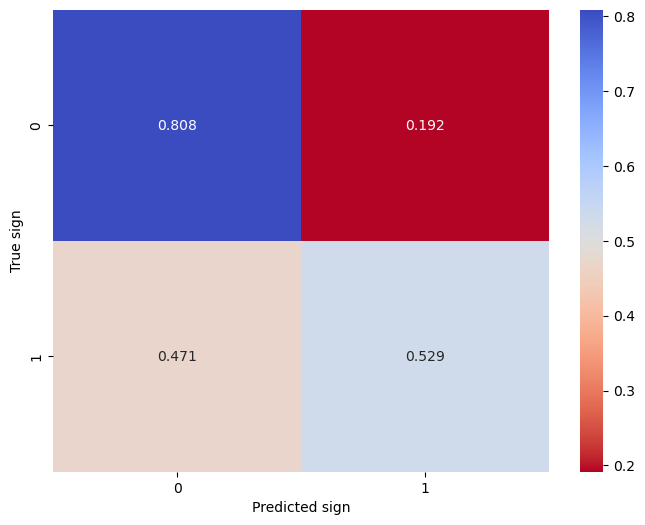

In [376]:
# Create the confusion matrix
matrix(y_test, y_pred)

                    0
std_22      17.680859
EURUSD=X    15.315921
range        9.061992
log_ret_1    6.550847
return       5.587663
SPY          5.579344
mm_200       1.733893
^GDAXI       1.639248
vol_ratio    0.381702
log_ret_3    0.204292
log_ret_2    0.118066
vol_ptc     -0.027227
mm_22       -0.659977
BTC-USD     -0.689060
GC=F        -0.970073
open_close  -0.984791
CL=F        -2.202085
NG=F        -2.504588
^VIX        -2.853774
mm_50       -3.303362
GOVT        -6.403965
USDJPY=X   -10.467140
^HSI       -11.941591
^N225      -14.817900


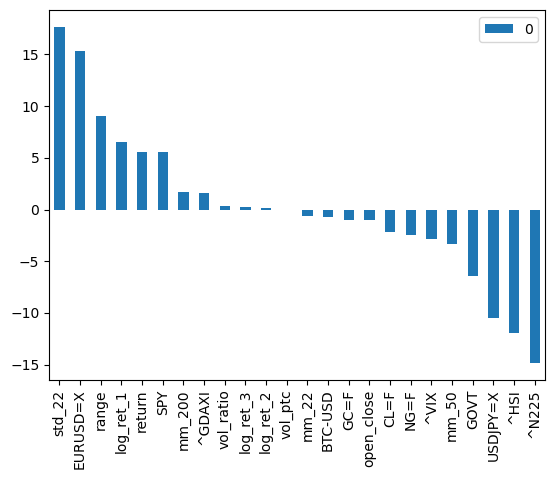

In [377]:
beta_coeff = pd.DataFrame(log_reg.coef_[0], index=X.columns).sort_values(0, ascending=False)
important_features = list(beta_coeff.index)
beta_coeff.plot(kind='bar')
print(beta_coeff)

In [378]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]

vif_data.sort_values(by='VIF', ascending=False, inplace=True)
print(vif_data.head())

      feature       VIF
13      range  8.556680
18      mm_50  8.258904
20     std_22  6.981250
15  vol_ratio  6.416992
17      mm_22  6.198843


## Backtest

In [379]:
test_df = pd.concat([my_factors, stock_filter], axis=1)[test_start : test_end]

test_df.dropna(inplace=True)
target = test_df[['next_gap']]

test_df.drop('next_gap', axis=1, inplace=True)
predict = log_reg.predict(test_df)
predict_prob = log_reg.predict_proba(test_df)

In [380]:
predict_prob = pd.Series(predict_prob[:,1],  index=test_df.index)
predict_prob.name = 'predict_prob'

predict = pd.Series(predict, index=test_df.index)
predict.name = 'predict'

In [381]:
results = pd.concat([stock, target, predict, predict_prob], axis=1)
results.dropna(inplace=True)

results['discrete_pnl'] = np.log1p(results['Gap'] * results['predict'])
results['cum_pnl'] = results['discrete_pnl'].cumsum()

results['predict_prob'] = results['predict_prob'].apply(lambda x: 1 if x > signal_threshold else 0)
results['continuos_pnl'] = np.log1p(results['Gap'] * results['predict_prob'])
results['custom_cum_pnl'] = results['continuos_pnl'].cumsum()
results

,Open,High,Low,Close,Adj Close,Volume,Gap,next_gap,predict,predict_prob,discrete_pnl,cum_pnl,continuos_pnl,custom_cum_pnl
Date,,,,,,,,,,,,,,
2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400,-0.008527,0.0,1.0,1,-0.008563,-0.008563,-0.008563,-0.008563
2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300,-0.002557,0.0,1.0,0,-0.002561,-0.011124,-0.000000,-0.008563
2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800,-0.010219,0.0,0.0,0,-0.000000,-0.011124,-0.000000,-0.008563
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600,0.014718,0.0,1.0,0,0.014610,0.003487,0.000000,-0.008563
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700,-0.026252,0.0,1.0,0,-0.026603,-0.023116,-0.000000,-0.008563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300,-0.002365,0.0,0.0,0,-0.000000,-0.011585,-0.000000,0.055826
2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100,-0.007220,0.0,0.0,0,-0.000000,-0.011585,-0.000000,0.055826
2023-04-27,152.639999,160.479996,152.369995,160.190002,160.190002,127015200,0.004432,0.0,0.0,0,0.000000,-0.011585,0.000000,0.055826


<Axes: xlabel='Date', ylabel='cum_pnl'>

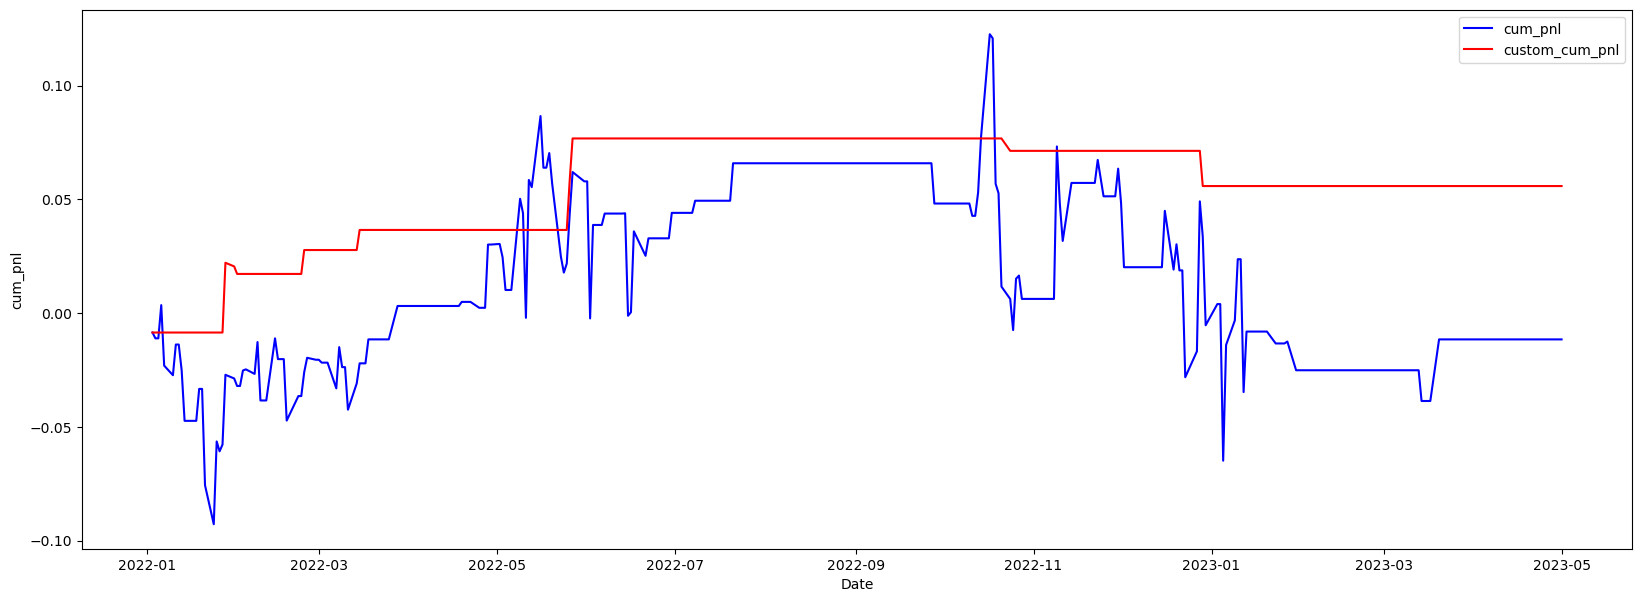

In [382]:
plt.figure(figsize=(20,7))
sns.lineplot(results['cum_pnl'], label='cum_pnl', color='blue')
sns.lineplot(results['custom_cum_pnl'], label='custom_cum_pnl', color='red')